In [1]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
# Define the output directory on the Desktop
output_dir = "C:/Users/shrey/Desktop/outputs"
os.makedirs(output_dir, exist_ok=True)
print(f"📂 Outputs folder created at: {output_dir}")

# Adjust Pandas display settings to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 1000)

📂 Outputs folder created at: C:/Users/shrey/Desktop/outputs


In [3]:
# 1. Load Datasets
loan_file_path = "C:/Users/shrey/Desktop/Loan.csv"
upi_file_path = "C:/Users/shrey/Desktop/UPI.csv"

loan_df = pd.read_csv(loan_file_path)
upi_df = pd.read_csv(upi_file_path)

In [4]:
# 2. Display Columns and Sample Data
print("📋 Columns in Loan.csv:")
for col in loan_df.columns:
    print(f" - {col}")
print("\n📄 First 5 rows of Loan.csv:")
print(loan_df.head())
print(f"\n✅ Successfully loaded Loan.csv with shape: {loan_df.shape}")

print("\n📋 Columns in UPI.csv:")
for col in upi_df.columns:
    print(f" - {col}")
print("\n📄 First 5 rows of UPI.csv:")
print(upi_df.head())
print(f"\n✅ Successfully loaded UPI.csv with shape: {upi_df.shape}")

📋 Columns in Loan.csv:
 - ApplicationDate
 - Age
 - AnnualIncome
 - CreditScore
 - EmploymentStatus
 - EducationLevel
 - Experience
 - LoanAmount
 - LoanDuration
 - MaritalStatus
 - NumberOfDependents
 - HomeOwnershipStatus
 - MonthlyDebtPayments
 - CreditCardUtilizationRate
 - NumberOfOpenCreditLines
 - NumberOfCreditInquiries
 - DebtToIncomeRatio
 - BankruptcyHistory
 - LoanPurpose
 - PreviousLoanDefaults
 - PaymentHistory
 - LengthOfCreditHistory
 - SavingsAccountBalance
 - CheckingAccountBalance
 - TotalAssets
 - TotalLiabilities
 - MonthlyIncome
 - UtilityBillsPaymentHistory
 - JobTenure
 - NetWorth
 - BaseInterestRate
 - InterestRate
 - MonthlyLoanPayment
 - TotalDebtToIncomeRatio
 - LoanApproved
 - RiskScore

📄 First 5 rows of Loan.csv:
  ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines

In [5]:
# 3. Preprocess Loan.csv for Credit Scoring
def preprocess_loan_data(loan_df):
    loan_df_original = loan_df.copy()
    loan_df_processed = loan_df.copy()
    
    loan_df_processed = loan_df_processed.fillna(loan_df_processed.median(numeric_only=True))
    loan_df_processed = loan_df_processed.fillna('Unknown')
    
    categorical_cols = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 
                        'LoanPurpose', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 
                        'UtilityBillsPaymentHistory']
    loan_df_processed = pd.get_dummies(loan_df_processed, columns=categorical_cols, drop_first=True)
    
    y = loan_df_processed['LoanApproved'].astype(int)
    X = loan_df_processed.drop(['LoanApproved', 'ApplicationDate', 'RiskScore'], axis=1, errors='ignore')
    
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return *train_test_split(X, y, test_size=0.2, random_state=42), X, y, loan_df_original

In [6]:
# 4. Train and Evaluate Credit Scoring Model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print("\n📊 Model Evaluation Report:\n", classification_report(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{output_dir}/roc_curve_loan.png")
    plt.show()
    plt.close()
    
    importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
    importances = importances.sort_values('Importance', ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=importances.head(5))
    plt.title("Top 5 Feature Importance")
    plt.savefig(f"{output_dir}/feature_importance_loan.png")
    plt.show()
    plt.close()
    
    return model, y_pred, y_prob

# 5. Anomaly Detection and Visualizations on Loan.csv
def anomaly_detection_loan(X, y, model, loan_df_original):
    data = X.copy()
    data['LoanApproved'] = y
    
    y_pred_full = model.predict(X)
    data['PredictedApproval'] = y_pred_full
    
    features = ['CreditScore', 'DebtToIncomeRatio', 'MonthlyIncome', 'LoanAmount']
    if all(col in data.columns for col in features):
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        data['Anomaly'] = iso_forest.fit_predict(data[features])
        data['Anomaly'] = data['Anomaly'].map({1: 0, -1: 1})
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='CreditScore', y='DebtToIncomeRatio', hue='Anomaly', style='LoanApproved', data=data)
        plt.title('Anomalies in Loan Data (CreditScore vs DebtToIncomeRatio)')
        plt.savefig(f"{output_dir}/anomalies_loan.png")
        plt.show()
        plt.close()
        
        print("\n🚨 Anomalies in Loan Data:\n", data[data['Anomaly'] == 1][features + ['LoanApproved', 'Anomaly']].head())
    else:
        print("⚠️ Required columns for anomaly detection not found in Loan.csv.")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='MonthlyDebtPayments', y='CreditCardUtilizationRate', hue='LoanApproved', size='CreditScore', data=loan_df_original)
    plt.title('Monthly Debt Payments vs Credit Card Utilization (Colored by Loan Approval)')
    plt.xlabel('Monthly Debt Payments')
    plt.ylabel('Credit Card Utilization Rate')
    plt.savefig(f"{output_dir}/monthly_debt_vs_credit_utilization.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='LoanApproved', y='MonthlyDebtPayments', hue='CreditCardUtilizationRate', data=loan_df_original)
    plt.title('Monthly Debt Payments by Loan Approval (Split by Credit Card Utilization)')
    plt.xlabel('Loan Approved (Proxy for Credit Score)')
    plt.ylabel('Monthly Debt Payments')
    plt.savefig(f"{output_dir}/monthly_debt_by_loan_approval.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='LoanPurpose', y='LoanAmount', hue='LoanApproved', data=loan_df_original)
    plt.title('Loan Amount by Loan Purpose (Split by Loan Approval)')
    plt.xticks(rotation=45)
    plt.xlabel('Loan Purpose')
    plt.ylabel('Loan Amount')
    plt.savefig(f"{output_dir}/loan_purpose_vs_loan_amount.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='NumberOfCreditInquiries', y='DebtToIncomeRatio', hue='LoanApproved', size='AnnualIncome', data=loan_df_original)
    plt.title('Debt-to-Income Ratio vs Number of Credit Inquiries (Colored by Loan Approval)')
    plt.xlabel('Number of Credit Inquiries')
    plt.ylabel('Debt-to-Income Ratio')
    plt.savefig(f"{output_dir}/dti_vs_credit_inquiries.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='HomeOwnershipStatus', y='NetWorth', hue='LoanApproved', split=True, data=loan_df_original)
    plt.title('Net Worth Distribution by Home Ownership Status (Split by Loan Approval)')
    plt.xlabel('Home Ownership Status')
    plt.ylabel('Net Worth')
    plt.savefig(f"{output_dir}/net_worth_by_home_ownership.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='JobTenure', y='AnnualIncome', hue='EmploymentStatus', style='LoanApproved', data=loan_df_original)
    plt.title('Job Tenure vs Annual Income by Employment Status (Styled by Loan Approval)')
    plt.xlabel('Job Tenure (Years)')
    plt.ylabel('Annual Income')
    plt.savefig(f"{output_dir}/job_tenure_vs_annual_income.png")
    plt.show()
    plt.close()
    
    return data

In [7]:
# 6. Extract Digital Footprints from UPI.csv
def extract_digital_footprints(upi_df):
    upi_df = upi_df.copy()
    
    # Convert date columns to datetime
    upi_df['Amount Sent DateTime'] = pd.to_datetime(upi_df['Amount Sent DateTime'])
    upi_df['Amount Received DateTime'] = pd.to_datetime(upi_df['Amount Received DateTime'])
    
    # Convert 'Transaction Amount' to numeric, handling non-numeric values
    upi_df['Transaction Amount'] = pd.to_numeric(upi_df['Transaction Amount'], errors='coerce')
    # Fill NaN values with 0 (or drop them if preferred)
    upi_df['Transaction Amount'] = upi_df['Transaction Amount'].fillna(0)
    
    # Debug: Check the data type and sample values
    print("Debug: 'Transaction Amount' data type:", upi_df['Transaction Amount'].dtype)
    print("Debug: Sample 'Transaction Amount' values:", upi_df['Transaction Amount'].head())
    
    # Rename 'Customer ID' to 'CustomerID' for consistency
    upi_df = upi_df.rename(columns={'Customer ID': 'CustomerID'})
    
    if 'CustomerID' not in upi_df.columns:
        raise KeyError("Column 'CustomerID' not found in UPI.csv after renaming. Available columns: " + str(upi_df.columns.tolist()))
    
    upi_summary = upi_df.groupby('CustomerID').agg({
        'Transaction Amount': ['sum', 'mean', 'std', 'count'],
        'Recipient ID': 'nunique',
        'Transaction Status': lambda x: (x == 'Completed').mean(),
        'Customer Age': 'first',
        'Transaction Category': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
        'Sender Bank': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
        'From State': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
        'UPI App': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
    }).reset_index()
    
    upi_summary.columns = [
        'CustomerID', 'TotalTransactionAmount', 'AvgTransactionAmount', 'StdTransactionAmount', 
        'TransactionFrequency', 'UniqueRecipients', 'SuccessRate', 'CustomerAge', 
        'MostCommonCategory', 'MostCommonBank', 'MostCommonState', 'MostCommonUPIApp'
    ]
    
    upi_summary['StdTransactionAmount'] = upi_summary['StdTransactionAmount'].fillna(0)
    upi_summary = upi_summary.fillna('Unknown')
    
    return upi_summary, upi_df

    
    

In [8]:
# 7. Visualize and Detect Anomalies in UPI.csv
def analyze_digital_footprints(upi_features, upi_df_original):
    # Visualization 1: Distribution of Total Transaction Amount
    plt.figure(figsize=(10, 6))
    sns.histplot(upi_features['TotalTransactionAmount'], bins=30)
    plt.title('Distribution of Total Transaction Amount (UPI Digital Footprint)')
    plt.xlabel('Total Transaction Amount')
    plt.ylabel('Count')
    plt.savefig(f"{output_dir}/upi_total_transaction_amount.png")
    plt.show()
    plt.close()

    # Visualization 2: Average Transaction Amount by Category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='MostCommonCategory', y='AvgTransactionAmount', data=upi_features)
    plt.title('Average Transaction Amount by Transaction Category (UPI Digital Footprint)')
    plt.xticks(rotation=45)
    plt.savefig(f"{output_dir}/upi_avg_transaction_by_category.png")
    plt.show()
    plt.close()

    # Visualization 3: Transaction Amount by UPI App
    plt.figure(figsize=(10, 6))
    print("Debug: Transaction Amount stats by UPI App:\n", upi_df_original.groupby('UPI App')['Transaction Amount'].describe())
    sns.boxplot(x='UPI App', y='Transaction Amount', data=upi_df_original)
    plt.title('Transaction Amount by UPI App')
    plt.xticks(rotation=45)
    plt.savefig(f"{output_dir}/upi_transaction_amount_by_app.png")
    plt.show()
    plt.close()

    # Visualization 4: Success Rate by UPI App
    plt.figure(figsize=(10, 6))
    success_by_app = upi_df_original.groupby('UPI App')['Transaction Status'].apply(lambda x: (x == 'Completed').mean()).reset_index()
    success_by_app.columns = ['UPI App', 'SuccessRate']
    print("Debug: Success Rates by UPI App:\n", success_by_app)
    sns.barplot(x='SuccessRate', y='UPI App', data=success_by_app)
    for index, value in enumerate(success_by_app['SuccessRate']):
        plt.text(value, index, f'{value:.3f}', va='center')
    plt.title('Success Rate by UPI App')
    plt.xlabel('Success Rate')
    plt.ylabel('UPI App')
    plt.xlim(0, 1)
    plt.savefig(f"{output_dir}/upi_success_rate_by_app.png")
    plt.show()
    plt.close()

    # Visualization 5: Customer Age by Most Common UPI App
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='MostCommonUPIApp', y='CustomerAge', data=upi_features)
    plt.title('Customer Age Distribution by Most Common UPI App')
    plt.xlabel('Most Common UPI App')
    plt.ylabel('Customer Age')
    plt.savefig(f"{output_dir}/upi_age_by_upi_app.png")
    plt.show()
    plt.close()

    # Visualization 6: Customer Age by Transaction Category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='MostCommonCategory', y='CustomerAge', data=upi_features)
    plt.title('Customer Age Distribution by Transaction Category')
    plt.xticks(rotation=45)
    plt.xlabel('Most Common Transaction Category')
    plt.ylabel('Customer Age')
    plt.savefig(f"{output_dir}/upi_age_by_category.png")
    plt.show()
    plt.close()

    # Visualization 7: Transaction Trends Over Time by Category
    upi_df_original['YearMonth'] = upi_df_original['Amount Sent DateTime'].dt.to_period('M')
    monthly_trends = upi_df_original.groupby(['YearMonth', 'Transaction Category'])['Transaction Amount'].mean().reset_index()
    
    # Debug: Check the data types and sample data
    print("Debug: monthly_trends dtypes:\n", monthly_trends.dtypes)
    print("Debug: monthly_trends sample:\n", monthly_trends.head())
    
    # Convert YearMonth to string for plotting
    monthly_trends['YearMonth'] = monthly_trends['YearMonth'].astype(str)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='YearMonth', y='Transaction Amount', hue='Transaction Category', data=monthly_trends)
    plt.title('Transaction Amount Trends Over Time by Transaction Category')
    plt.xticks(rotation=45)
    plt.xlabel('Year-Month')
    plt.ylabel('Average Transaction Amount')
    plt.savefig(f"{output_dir}/upi_transaction_trends_over_time.png")
    plt.show()
    plt.close()

    # Visualization 8: Sender vs Receiver Bank Heatmap
    bank_cross_tab = pd.crosstab(upi_df_original['Sender Bank'], upi_df_original['Receiver Bank'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(bank_cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Transaction Volume Between Sender and Receiver Banks')
    plt.xlabel('Receiver Bank')
    plt.ylabel('Sender Bank')
    plt.savefig(f"{output_dir}/upi_bank_transaction_heatmap.png")
    plt.show()
    plt.close()

    # Visualization 9: Payment Method vs Status vs Device
    plt.figure(figsize=(12, 6))
    success_by_method_device = upi_df_original.groupby(['Payment Method', 'Transaction Device'])['Transaction Status'] \
        .apply(lambda x: (x == 'Completed').mean()).reset_index()
    success_by_method_device.columns = ['Payment Method', 'Transaction Device', 'SuccessRate']
    sns.barplot(x='SuccessRate', y='Payment Method', hue='Transaction Device', data=success_by_method_device)
    plt.title('Success Rate by Payment Method and Transaction Device')
    plt.xlabel('Success Rate')
    plt.ylabel('Payment Method')
    plt.savefig(f"{output_dir}/upi_payment_method_vs_device_success.png")
    plt.show()
    plt.close()

    # Visualization 10: State-wise Transaction Flow
    state_flow = upi_df_original.groupby(['From State', 'To State'])['Transaction Amount'].sum().reset_index()
    state_flow = state_flow[state_flow['Transaction Amount'] > 0]
    state_flow['StatePair'] = state_flow['From State'] + ' -> ' + state_flow['To State']
    merged_flow = state_flow.merge(
        upi_df_original[['From State', 'To State', 'Transaction Category']],
        on=['From State', 'To State'],
        how='left'
    ).drop_duplicates()
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Transaction Amount', y='StatePair', hue='Transaction Category', data=merged_flow)
    plt.title('Transaction Amount Flow Between States (Colored by Transaction Category)')
    plt.xlabel('Total Transaction Amount')
    plt.ylabel('State Pair (From -> To)')
    plt.savefig(f"{output_dir}/upi_state_transaction_flow.png")
    plt.show()
    plt.close()

    # Anomaly Detection
    features = ['TotalTransactionAmount', 'AvgTransactionAmount', 'TransactionFrequency', 'UniqueRecipients', 'SuccessRate']
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    upi_features['Anomaly'] = iso_forest.fit_predict(upi_features[features])
    upi_features['Anomaly'] = upi_features['Anomaly'].map({1: 0, -1: 1})

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='TransactionFrequency',
        y='AvgTransactionAmount',
        hue='Anomaly',
        size='TotalTransactionAmount',
        data=upi_features
    )
    plt.title('Anomalies in UPI Data (TransactionFrequency vs AvgTransactionAmount)')
    plt.savefig(f"{output_dir}/anomalies_upi.png")
    plt.show()
    plt.close()

    print("\n🚨 Anomalies in UPI Data:\n", upi_features[upi_features['Anomaly'] == 1][features + ['Anomaly']].head())

    return upi_features



📊 Model Evaluation Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      2983
           1       0.93      0.64      0.76      1017

    accuracy                           0.90      4000
   macro avg       0.91      0.81      0.85      4000
weighted avg       0.90      0.90      0.89      4000



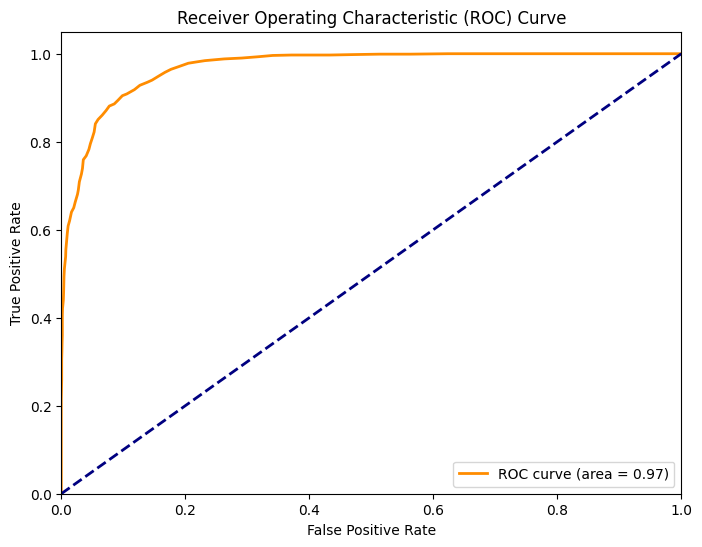

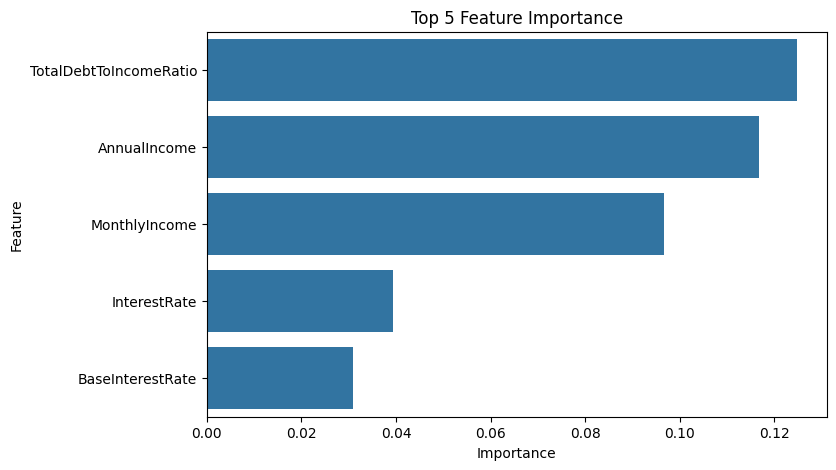

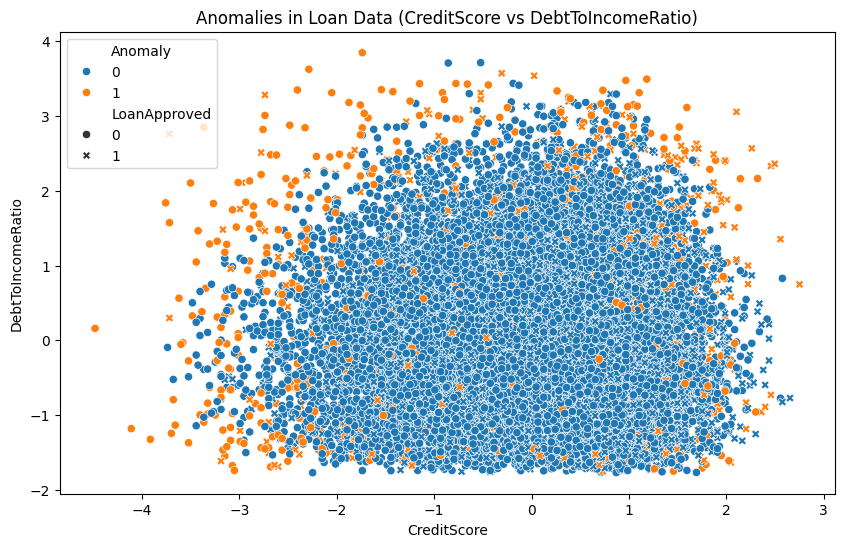


🚨 Anomalies in Loan Data:
     CreditScore  DebtToIncomeRatio  MonthlyIncome  LoanAmount  LoanApproved  Anomaly
22     1.242990           2.151680       1.403312   -1.122646             1        1
39     1.635177          -1.328131       2.644128   -0.896164             1        1
45    -0.815992           2.093074       1.194542    2.167569             0        1
54     0.282131          -0.097232       5.409276   -0.384735             1        1
72     0.929240          -1.703433       3.330220    0.298734             1        1


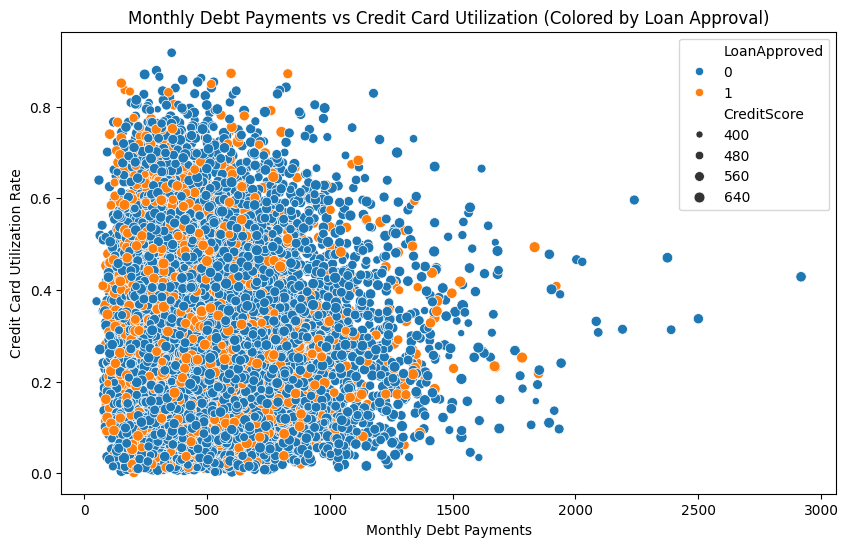

C:\Users\shrey\AppData\Local\Temp\ipykernel_7784\3828732282.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{output_dir}/monthly_debt_by_loan_approval.png")
C:\Users\shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


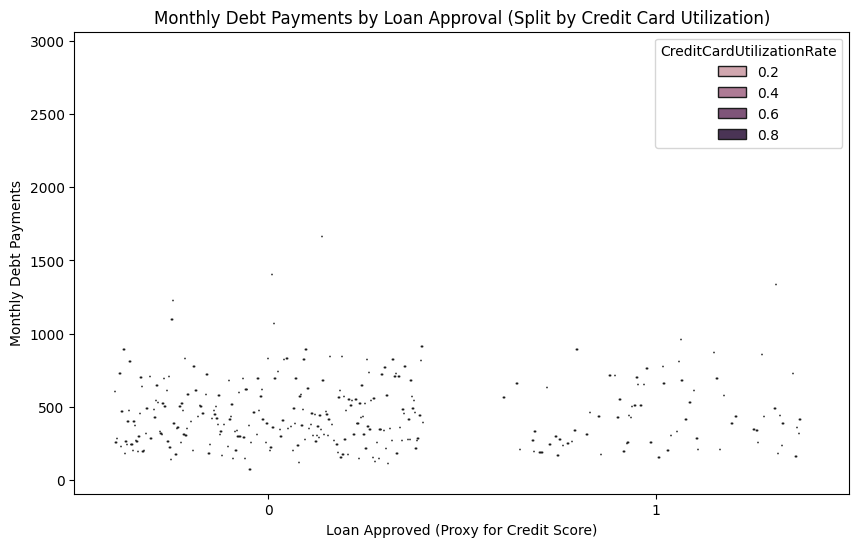

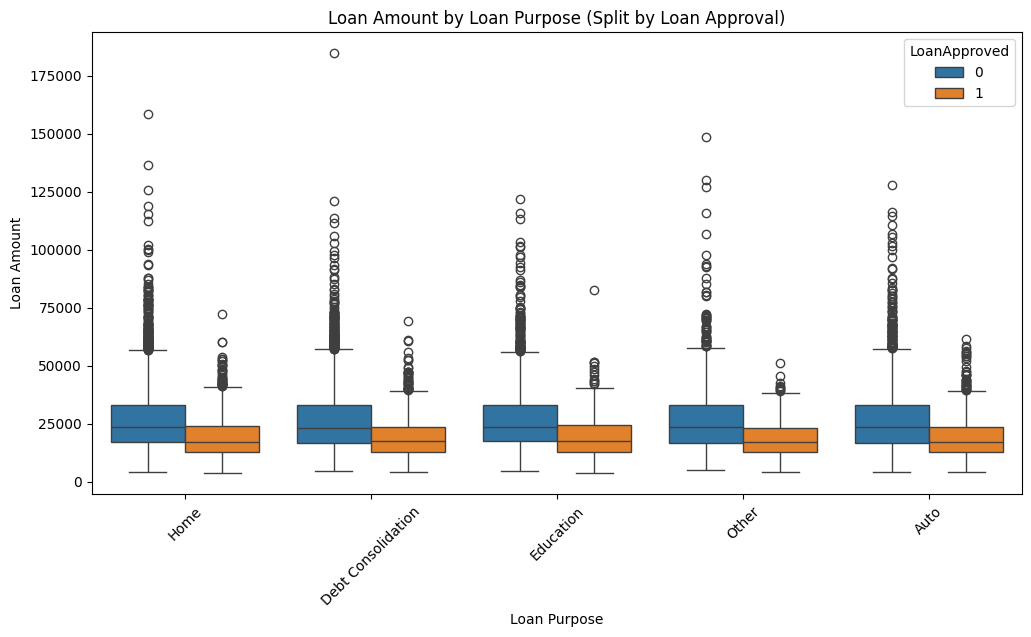

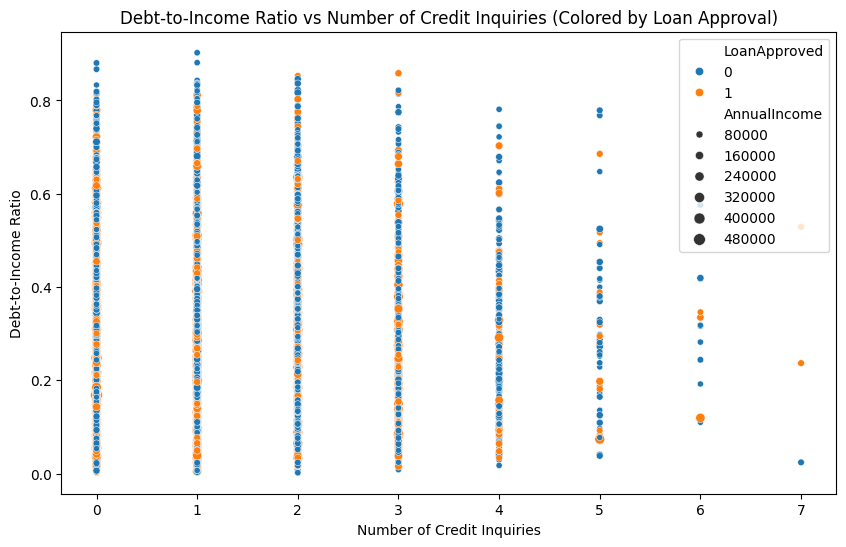

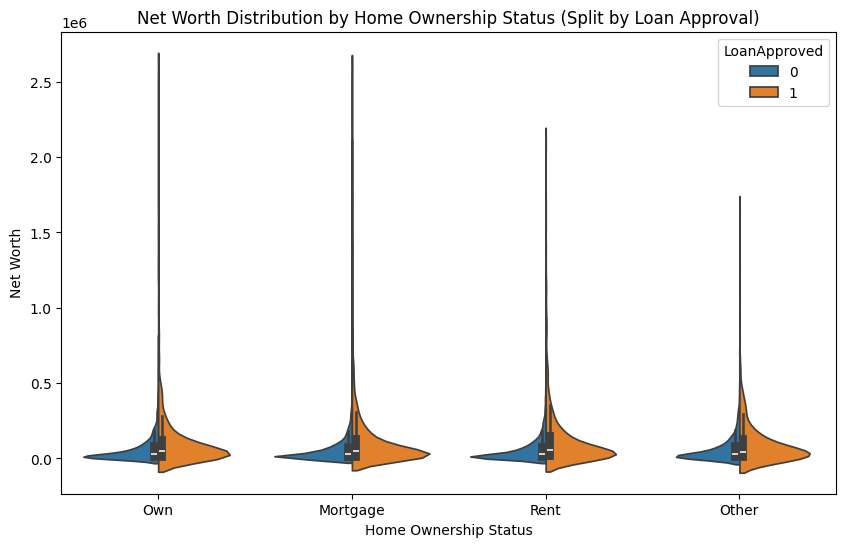

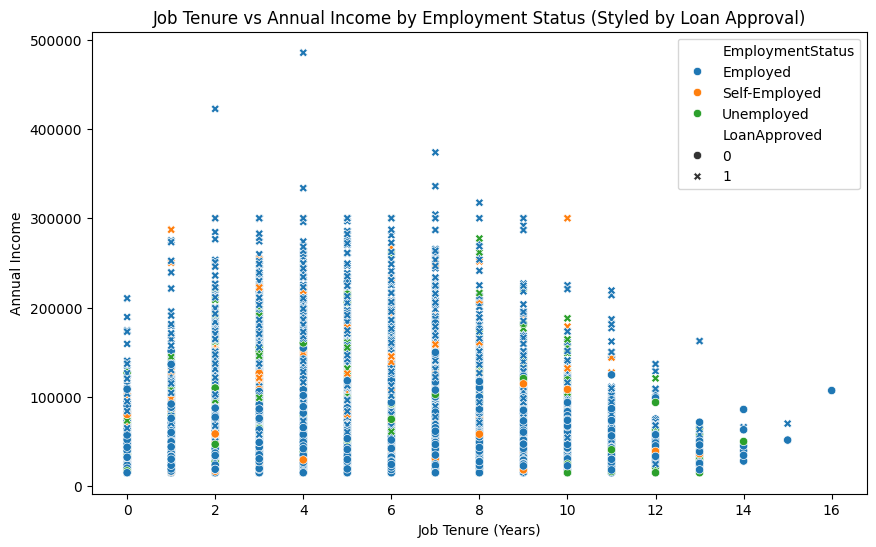

Debug: 'Transaction Amount' data type: float64
Debug: Sample 'Transaction Amount' values: 0    14993.73
1     2534.80
2    10478.46
3      471.46
4    63391.63
Name: Transaction Amount, dtype: float64


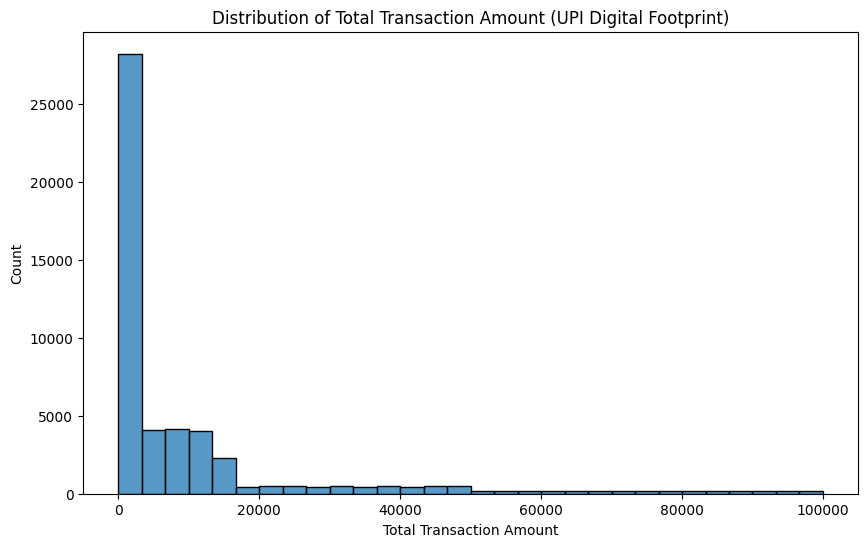

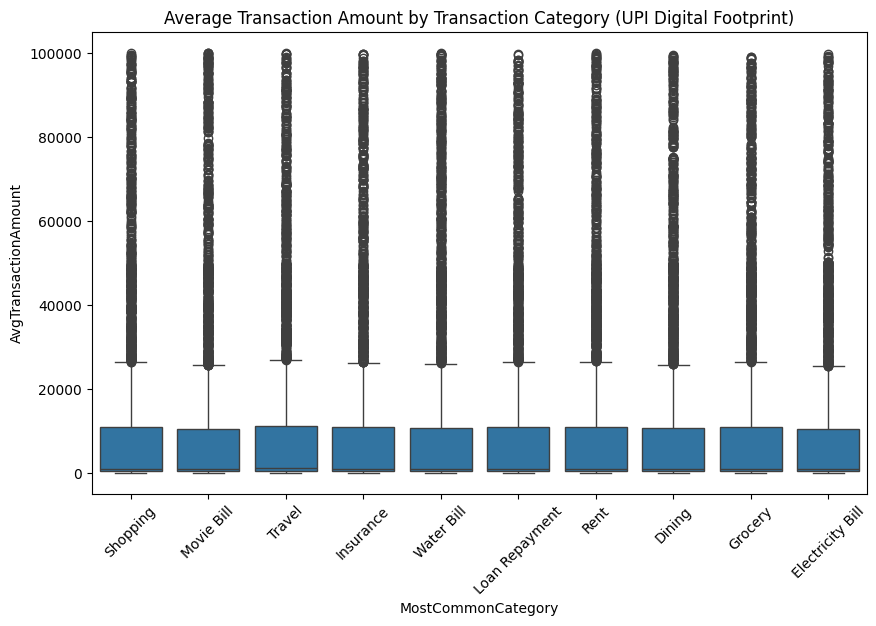

Debug: Transaction Amount stats by UPI App:
               count          mean           std    min       25%      50%         75%       max
UPI App                                                                                        
Amazon Pay   9942.0   9663.769686  17700.280786  10.60  507.1625  986.090  10654.5975  99909.06
Google Pay  10020.0  10009.141143  18310.746920  10.85  508.8575  997.260  10715.5000  99733.42
Mobikwik    10060.0  10082.782994  18430.677318  10.02  501.8000  992.415  10960.2600  99956.85
Paytm        9933.0   9752.802914  17744.770160  10.34  507.5600  997.970  10884.2000  99995.24
PhonePe     10045.0   9974.901291  18277.365162  10.05  501.0100  988.500  10778.3200  99959.60


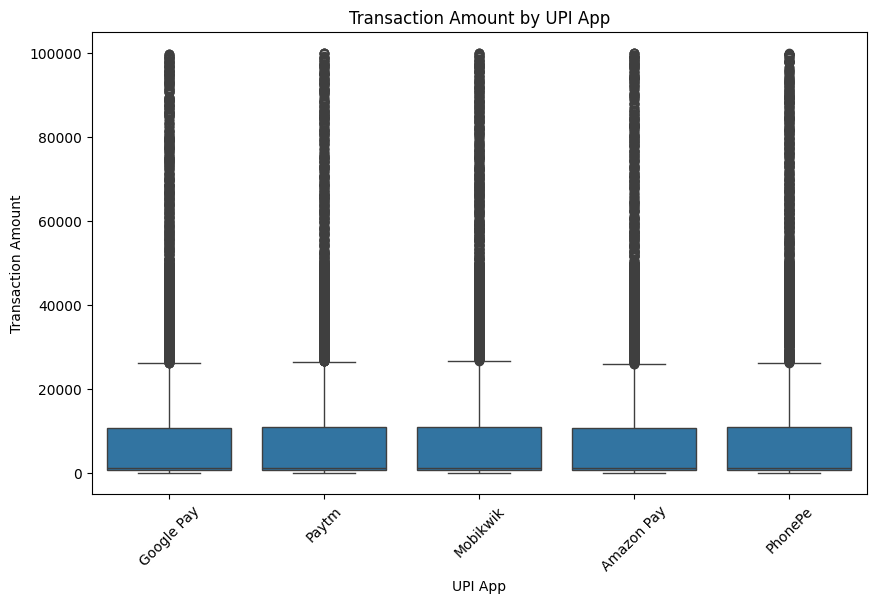

Debug: Success Rates by UPI App:
       UPI App  SuccessRate
0  Amazon Pay          0.0
1  Google Pay          0.0
2    Mobikwik          0.0
3       Paytm          0.0
4     PhonePe          0.0


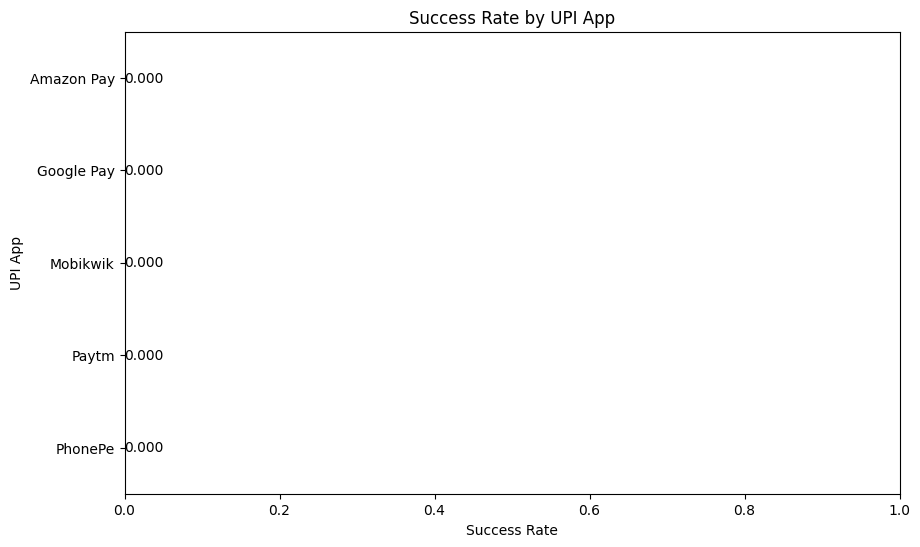

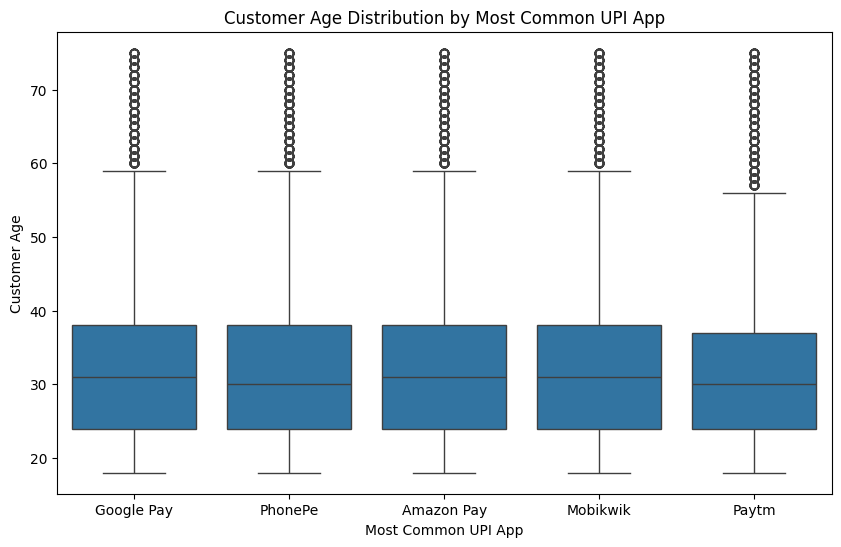

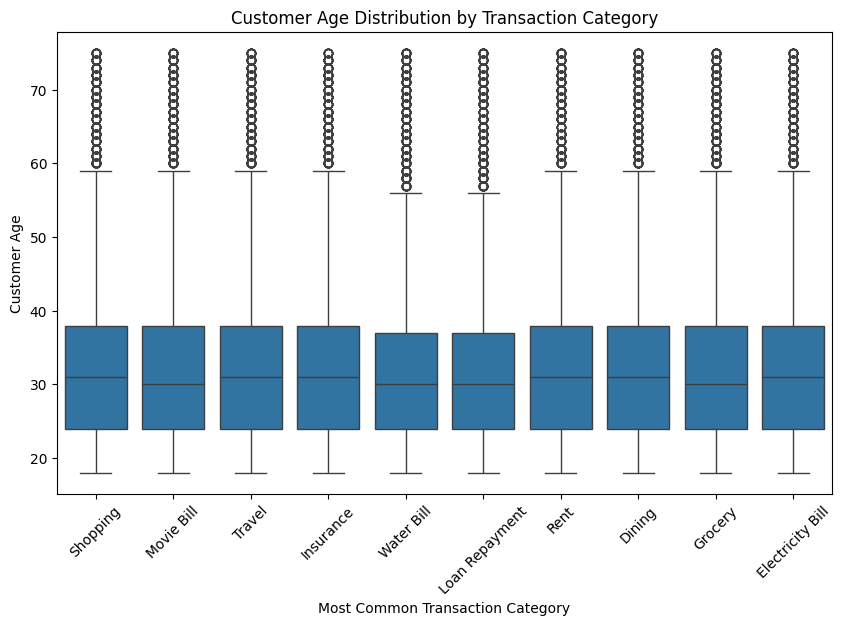

Debug: monthly_trends dtypes:
 YearMonth               period[M]
Transaction Category       object
Transaction Amount        float64
dtype: object
Debug: monthly_trends sample:
   YearMonth Transaction Category  Transaction Amount
0   2023-06               Dining         8961.899769
1   2023-06     Electricity Bill        10739.995734
2   2023-06              Grocery         9550.287939
3   2023-06            Insurance         9849.856066
4   2023-06       Loan Repayment        10544.608906


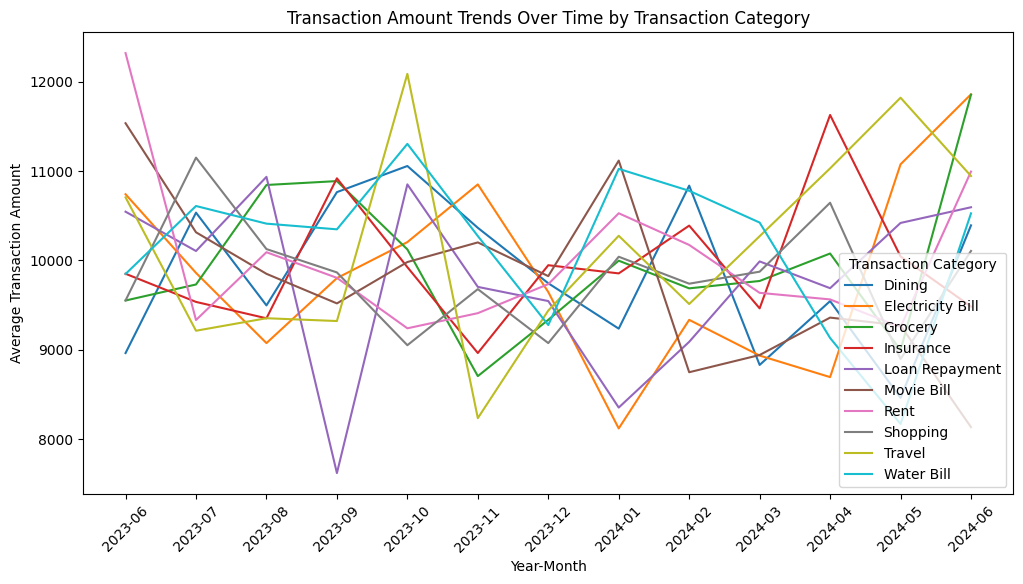

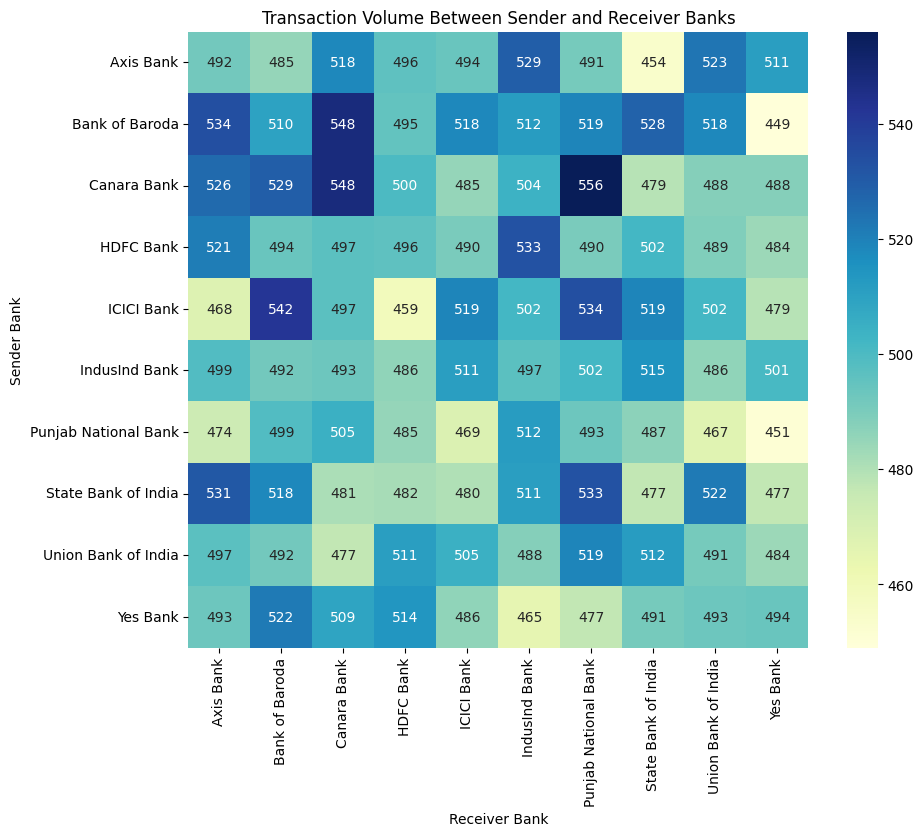

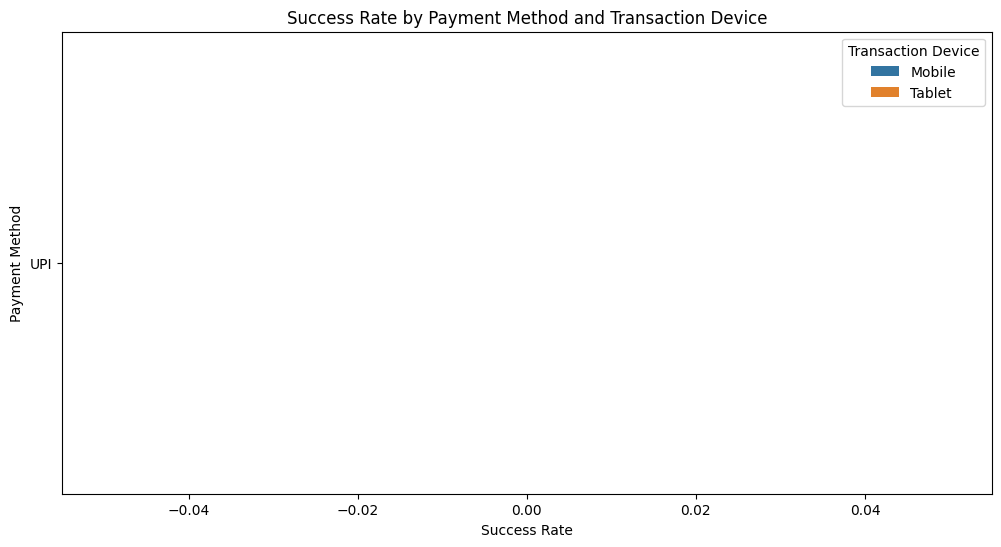

C:\Users\shrey\AppData\Local\Temp\ipykernel_7784\185628713.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{output_dir}/upi_state_transaction_flow.png")
C:\Users\shrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


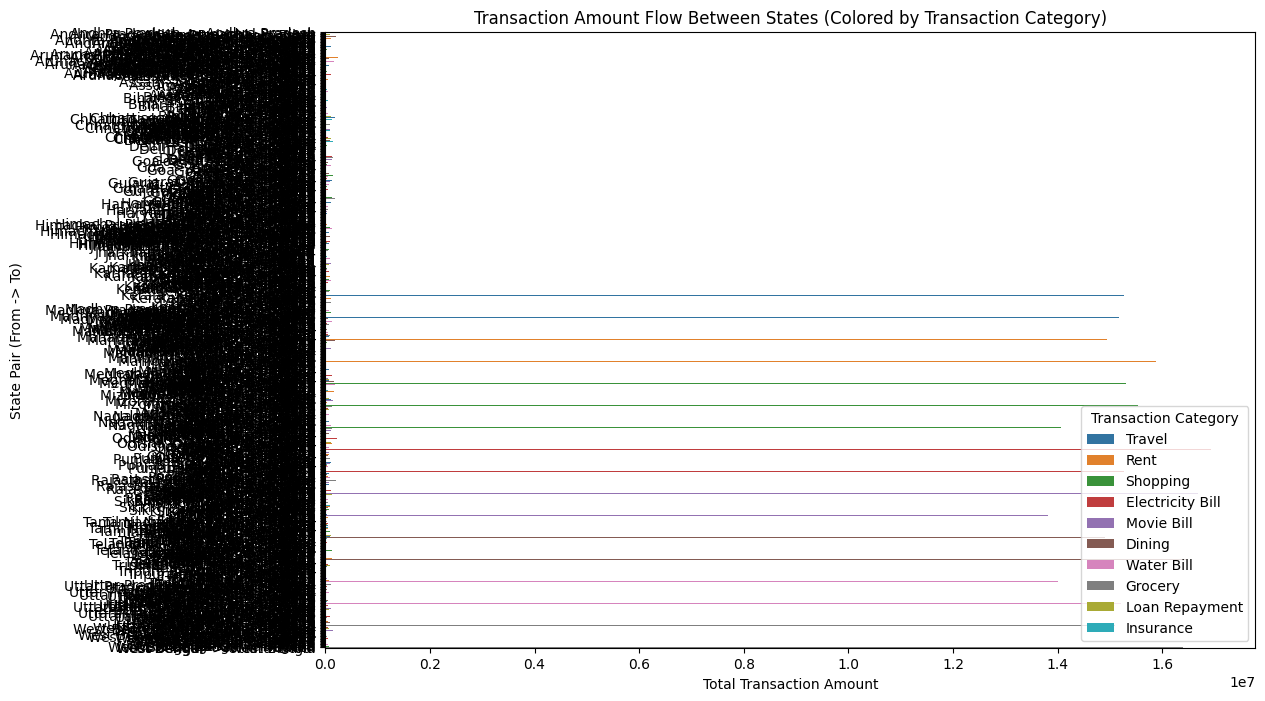

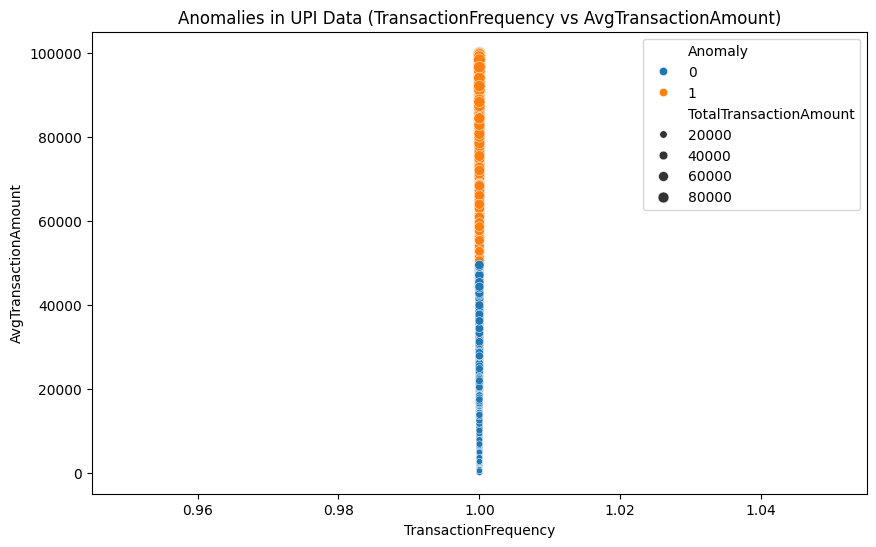


🚨 Anomalies in UPI Data:
      TotalTransactionAmount  AvgTransactionAmount  TransactionFrequency  UniqueRecipients  SuccessRate  Anomaly
15                 62590.89              62590.89                     1                 1          0.0        1
38                 64741.16              64741.16                     1                 1          0.0        1
71                 89489.49              89489.49                     1                 1          0.0        1
217                55863.67              55863.67                     1                 1          0.0        1
263                52175.46              52175.46                     1                 1          0.0        1

🏁 Pipeline Completed!


In [9]:
# 8. Run the Pipeline
X_train, X_test, y_train, y_test, X_loan, y_loan, loan_df_original = preprocess_loan_data(loan_df)
model, y_pred, y_prob = train_and_evaluate(X_train, X_test, y_train, y_test)
loan_with_anomalies = anomaly_detection_loan(X_loan, y_loan, model, loan_df_original)
upi_features, upi_df_original = extract_digital_footprints(upi_df)
upi_with_anomalies = analyze_digital_footprints(upi_features, upi_df_original)

print("\n🏁 Pipeline Completed!")